# IST 718 | Final Project | Playground | Group/Team 2

### Project Overview:
- Classifying radiology images: Normal vs Pneumonia
- [Click here to find the dataset on Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

The first model utilizes a pre-trained computer vision model called 'ResNet18' on radiology image data.  The model is then fine tuned on the data.  The deep learning model is tuned with three (3) epochs with a theoretical error rate of 1.1% and is exported to a `.pkl` file for future use.
Then on top of that, we modified the parameter to include ResNet50 and ResNet152.

The second model utilizes VVG-16 on radiology image. The model is a convolutional neural network model that's used for image recognition. It's unique in that it has only 16 layers that have weights, as opposed to relying on a large number of hyper-parameters. Therefore, it is less computational expensive with relatively high accuracy.

### Configuring Google Drive, Kaggle
- Create free Kaggle API key
  - Needed to download the dataset from Kaggle
- Upload kaggle.json to Google Drive
  - Kaggle configuration settings
- Mount Google Drive to Colab
  - Data source copy directory
- Ensure Colab has GPU settings turned on for training

In [ ]:
#Meichan:
#Import necessary packages for analysis
import numpy as np
import pandas as pd

#For Tensorflow and kera packages
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc



In [ ]:
!python -V

Python 3.10.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Select the directory where the Kaggle.json, notebook, and the dataset will be stored.
%cd '/content/drive/MyDrive/IST 718/Final Project'

/content/drive/MyDrive/IST 718/Final Project


In [ ]:
%ls -a

 IST_718_Group_2_Final_Project_Final.ipynb  'kaggle (2).json'
'kaggle (1).json'                            kaggle.json


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/IST 718/Final Project'

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:16<00:00, 179MB/s]
100% 2.29G/2.29G [00:16<00:00, 146MB/s]


In [ ]:
!unzip '/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia.zip' -d '/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/IST 718/Final Project/chest-xray

### Review Data Samples and Data Preprocessing for Tensorflow

- Descriptive analysis of the dataset: train vs. test
- Preprocess the image size for better learning effect

Examples of 3 'normal' cases:

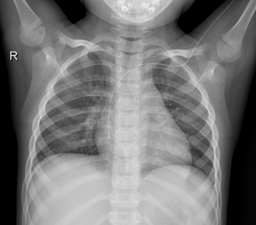

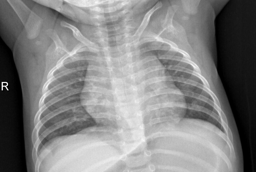

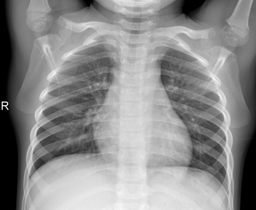

In [ ]:
import os
import random
from PIL import Image

# Set the seed for the random number generator
random.seed(69)

# Set the path of the directory containing the images
dir_path = '/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train/NORMAL/'

# Get a list of all the image files in the directory
files = [f for f in os.listdir(dir_path) if f.endswith('.jpeg')]

# Choose 3 random files from the list
random_files = random.sample(files, 3)

# Loop through each file and print it to the screen as a thumbnail
for file in random_files:
    im = Image.open(os.path.join(dir_path, file))
    im.thumbnail((256, 256))
    im.show()

Examples of 3 'abnormal' cases:

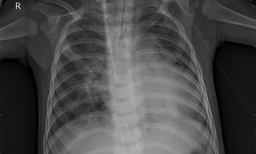

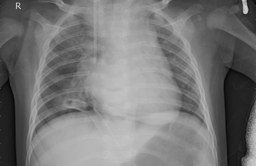

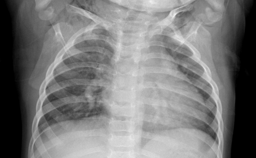

In [ ]:
# Set the seed for the random number generator
random.seed(69)

# Set the path of the directory containing the images
dir_path = '/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'

# Get a list of all the image files in the directory
files = [f for f in os.listdir(dir_path) if f.endswith('.jpeg')]

# Choose 3 random files from the list
random_files = random.sample(files, 3)

# Loop through each file and print it to the screen as a thumbnail
for file in random_files:
    im = Image.open(os.path.join(dir_path, file))
    im.thumbnail((256, 256))
    im.show()

Data augmentation and preprocessing for the image size - Meichan

In [ ]:
## Overall parameter set up
FINE_TUNING_EPOCHS = 5
TRAINING_EPOCHS = 3
BATCH_SIZE = 32

image_height = 299
image_width = 299

In [ ]:
##Meichan: Data agumentation and pre-processing using tensorflow with the train data
gen = ImageDataGenerator(rescale = 1./255,
                         zoom_range = 0.05,
                         width_shift_range = 0.05,
                         height_shift_range = 0.05,
                         brightness_range = [0.95,1.05])

train_generator = gen.flow_from_directory(
    directory = '/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train/',
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 5216 images belonging to 2 classes.


In [ ]:
#Image preprocessing for the validation dataset
validation_generator = gen.flow_from_directory(
    directory   = "/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/val", # images data path for validation data
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

Found 16 images belonging to 2 classes.


In [ ]:
#Image preprocessing for the test dataset
test_generator = gen.flow_from_directory(
    directory   = "/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test", # images data path / folder in which images are ther
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

Found 624 images belonging to 2 classes.


In [ ]:
# Get labels in dataset. There are two types of labels for the train dataset, NORMAL and PNEUMONIA
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list
class_names

['NORMAL', 'PNEUMONIA']

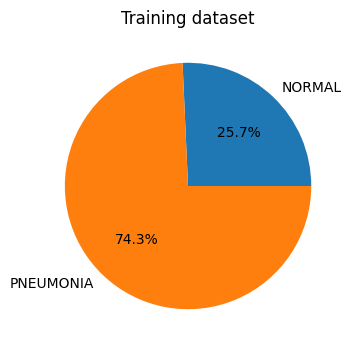

In [ ]:
# Count the frequency of the normal/pneumonia in the dataset and see if the data was balanced for the model training.
freq = np.unique(train_generator.classes, return_counts=True)

#Visualize the composition of the class label
plt.title("Training dataset")
plt.pie(freq[1], labels = class_names, autopct='%1.1f%%');


#Clearly the data is imbalanced. Therefore we perform class weight adjustment using sklearn

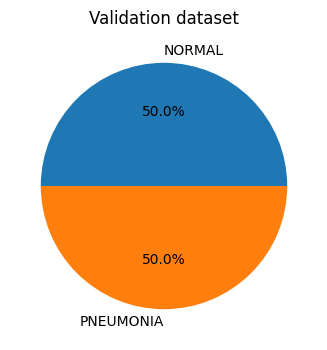

In [ ]:
# Count the frequency of the normal/pneumonia in the dataset and see if the data was balanced for the model training.
freq = np.unique(validation_generator.classes, return_counts=True)

#Visualize the composition of the class label
plt.title("Validation dataset")
plt.pie(freq[1], labels = class_names, autopct='%1.1f%%');


#Clearly the data is imbalanced. Therefore we perform class weight adjustment using sklearn

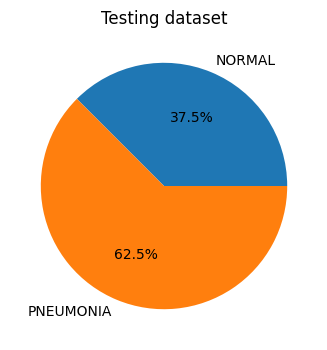

In [ ]:
# Count the frequency of the normal/pneumonia in the dataset and see if the data was balanced for the model training.
freq2 = np.unique(test_generator.classes, return_counts=True)

#Visualize the composition of the class label
plt.title("Testing dataset")
plt.pie(freq2[1], labels = class_names, autopct='%1.1f%%');


#Clearly the data is imbalanced. Therefore we perform class weight adjustment using sklearn

In [ ]:
#Class weight adjustment
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [ ]:
# Create a function to visualize the train dataset x-ray files
def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            plt.title(class_names[np.argmax(true_labels[i])])

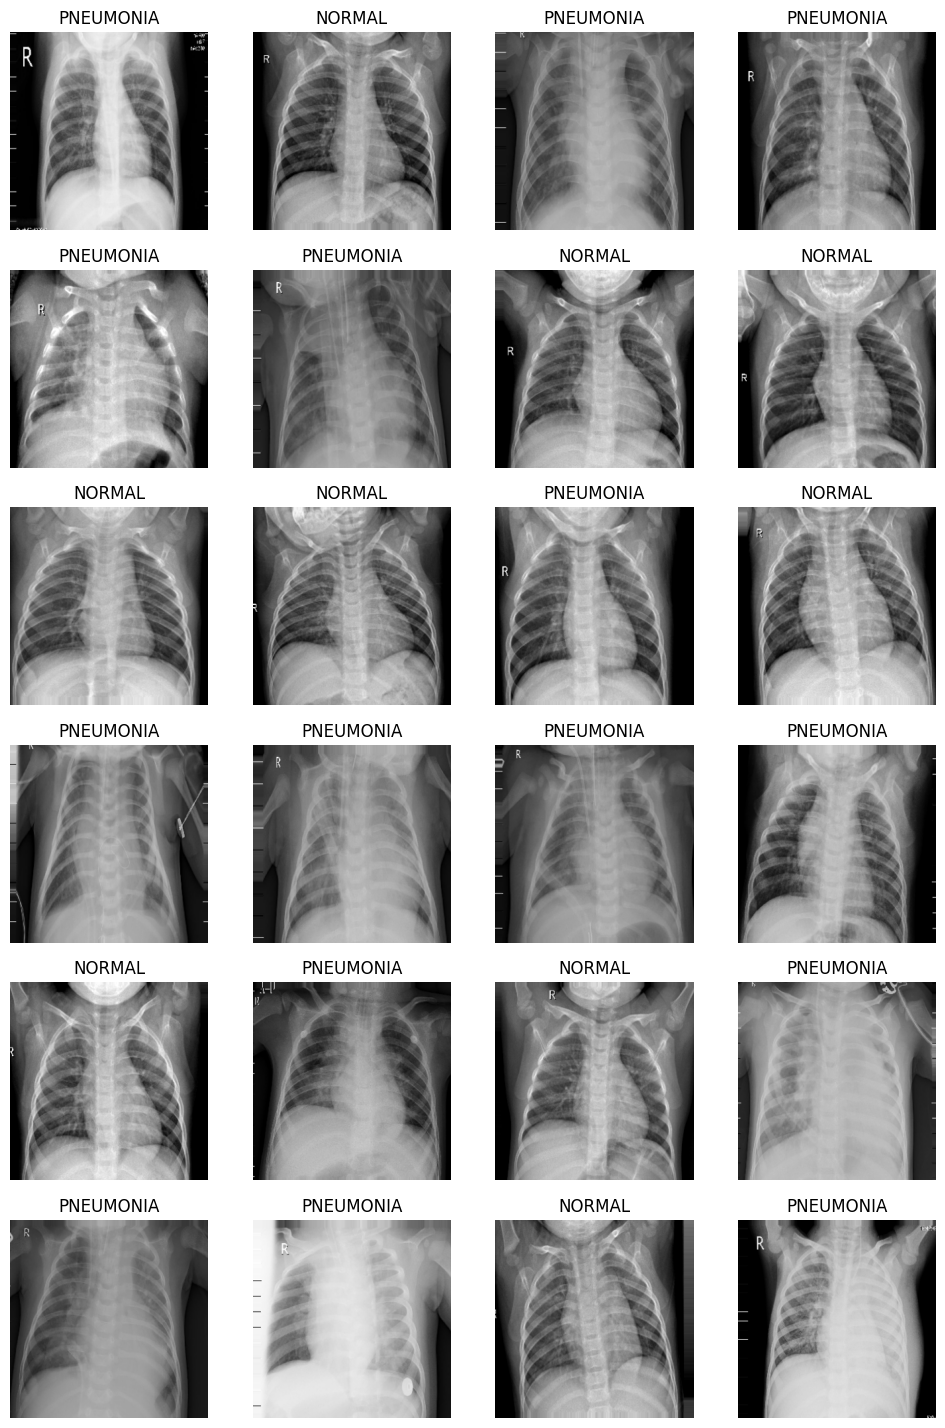

In [ ]:
#Random pictures of the train set
x,y = next(train_generator)
plot_images(x,y)

### Model 1: Train fastai Model - Major contribution by Matthew :-)
- Tip
  - Make sure you have your Colab GPU settings turned on...or training will take....wait for it.....forever :-)

In [ ]:
from fastai.vision.all import *

In [ ]:
path = Path('/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train')
path

Path('/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/train')

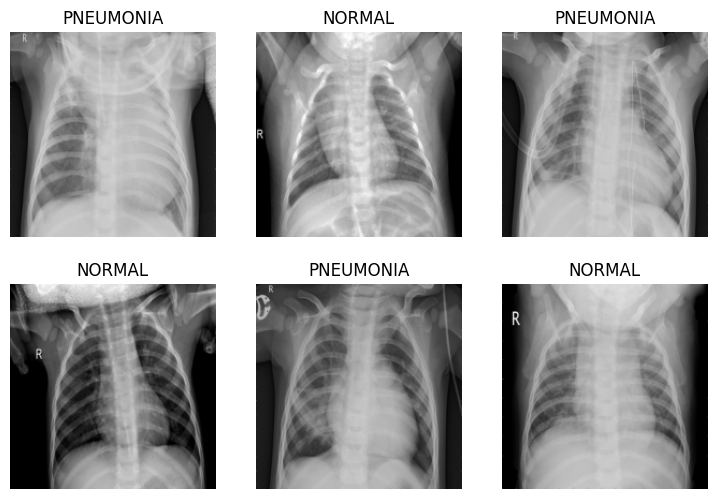

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 24.8MB/s]


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/IST 718/Final Project'

# Save the model for future use
learn.export(f"{os.environ['KAGGLE_CONFIG_DIR']}/IST_718_Group-2_Radiology_Model_Classifier.pkl'")

In [ ]:
# Load the model
learn = load_learner(f"{os.environ['KAGGLE_CONFIG_DIR']}/IST_718_Group-2_Radiology_Model_Classifier.pkl'")
learn

### Test Prediction on Sample Image

In [ ]:
is_normal,_,probs = learn.predict(PILImage.create('/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg'))
print(f"This is a: {is_normal}.")
print(f"Probability of normal chest x-ray without findings: {probs[0]:.4f}")

This is a: NORMAL.
Probability of normal chest x-ray without findings: 0.9998


# Overview of Model Architecture | Diagram

In [ ]:
!pip install -Uqq graphviz

import graphviz
def gv(s):
  return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

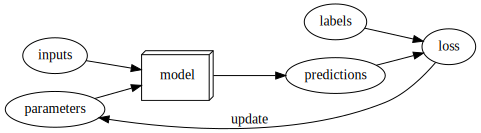

In [ ]:
gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=model]
inputs->model->predictions; parameters->model; labels->loss; predictions->loss
loss->parameters[constraint=false label=update]''')

### Predict on Test Data

In [ ]:
test_path = Path('/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test')
test_files = get_image_files(test_path)
test_dl = dls.test_dl(test_files)
preds = learn.get_preds(dl=test_dl)

In [ ]:
pred_labels = preds[0].argmax(dim=1)
pred_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
pred_class_names = [dls.vocab[label] for label in pred_labels]
pred_class_names

['NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'PNEUMONIA',
 'NORMAL',
 'PNEUMONIA',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'PNEUMONIA',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'PNEUMONIA',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'PNEUMONIA',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'PNEUMONIA',
 'NORMAL',
 'PNEUMONIA',
 'PNEUMONIA',
 'NORMAL',
 'NORMAL',
 'PNEUMONIA',
 'NORMAL',
 'NORMAL',
 'PNEUMONIA',
 'PNEUMONIA',
 'NORMAL',
 'PNEUMONIA',
 'PNEUMONIA',
 'NORMAL',
 'PNEUMONIA',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'PNEUMONIA',
 'PNEUMONIA',
 'NORMAL',
 'PNEUMONIA',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'PNEUMONIA',
 'PNEUMONIA',
 'NORMAL',
 'NORMAL',
 'NORMAL

In [ ]:
true_labels = [parent_label(img) for img in test_files]
correct_predictions = sum([true == pred for true, pred in zip(true_labels, pred_class_names)])
accuracy = correct_predictions / len(test_files) * 100


In [ ]:
for img_file, pred_class in zip(test_files, pred_class_names):
    print(f"{img_file}: {pred_class}")


/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0013-0001.jpeg: NORMAL
/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0010-0001.jpeg: NORMAL
/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0009-0001.jpeg: NORMAL
/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0016-0001.jpeg: NORMAL
/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0011-0001.jpeg: NORMAL
/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0005-0001.jpeg: NORMAL
/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg: NORMAL
/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg: NORMAL
/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/ches

In [ ]:
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 84.78%


### Train using `resnet50`

In [ ]:
learn50 = vision_learner(dls, resnet50, metrics=error_rate)
learn50.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


In [ ]:
import os

# Save the model for future use
learn50.export(f"{os.environ['KAGGLE_CONFIG_DIR']}/IST_718_Group-2_Radiology_Model_Classifier_resnet50.pkl'")

In [ ]:
# Load the model
learn50 = load_learner(f"{os.environ['KAGGLE_CONFIG_DIR']}/IST_718_Group-2_Radiology_Model_Classifier_resnet50.pkl'")
learn50

In [ ]:
test_path = Path('/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test')
test_files = get_image_files(test_path)
test_dl = dls.test_dl(test_files)
preds50 = learn50.get_preds(dl=test_dl)

pred_labels50 = preds50[0].argmax(dim=1)
pred_labels50

pred_class_names50 = [dls.vocab[label] for label in pred_labels50]
pred_class_names50

true_labels = [parent_label(img) for img in test_files]
correct_predictions = sum([true == pred for true, pred in zip(true_labels, pred_class_names50)])
accuracy50 = correct_predictions / len(test_files) * 100

print(f"Accuracy: {accuracy50:.2f}%")

Accuracy: 81.89%


## Train with Resnet152

In [ ]:
learn152 = vision_learner(dls, resnet152, metrics=error_rate)
learn152.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 49.3MB/s]


In [ ]:
import os

# Save the model for future use
learn152.export(f"{os.environ['KAGGLE_CONFIG_DIR']}/IST_718_Group-2_Radiology_Model_Classifier_resnet152.pkl'")

# Load the model
learn152 = load_learner(f"{os.environ['KAGGLE_CONFIG_DIR']}/IST_718_Group-2_Radiology_Model_Classifier_resnet152.pkl'")
learn152

In [ ]:
test_path = Path('/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test')
test_files = get_image_files(test_path)
test_dl = dls.test_dl(test_files)
preds152 = learn152.get_preds(dl=test_dl)

pred_labels152 = preds152[0].argmax(dim=1)
pred_labels152

pred_class_names152 = [dls.vocab[label] for label in pred_labels152]
pred_class_names152

true_labels = [parent_label(img) for img in test_files]
correct_predictions = sum([true == pred for true, pred in zip(true_labels, pred_class_names152)])
accuracy152 = correct_predictions / len(test_files) * 100

print(f"Accuracy: {accuracy152:.2f}%")

Accuracy: 85.58%


## Find optimal learning rate

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0010000000474974513)

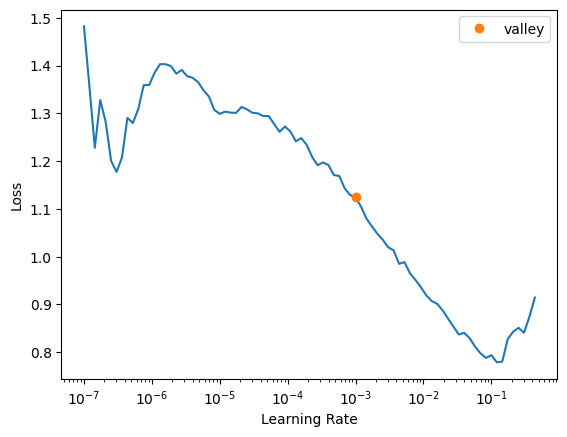

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.lr_find()

In [ ]:
learn.fine_tune(3, base_lr=0.0010000000474974513)

In [ ]:
# Save the model for future use
learn.export(f"{os.environ['KAGGLE_CONFIG_DIR']}/IST_718_Group-2_Radiology_Model_Classifier_optimal_lr.pkl'")

# Load the model
learn = load_learner(f"{os.environ['KAGGLE_CONFIG_DIR']}/IST_718_Group-2_Radiology_Model_Classifier_optimal_lr.pkl'")
learn

test_path = Path('/content/drive/MyDrive/IST 718/Final Project/chest-xray-pneumonia/chest_xray/test')
test_files = get_image_files(test_path)
test_dl = dls.test_dl(test_files)
preds = learn.get_preds(dl=test_dl)

pred_labels = preds[0].argmax(dim=1)
pred_labels

pred_class_names = [dls.vocab[label] for label in pred_labels]
pred_class_names

true_labels = [parent_label(img) for img in test_files]
correct_predictions = sum([true == pred for true, pred in zip(true_labels, pred_class_names)])
accuracy_optimal_lr = correct_predictions / len(test_files) * 100

print(f"Accuracy: {accuracy_optimal_lr:.2f}%")

Accuracy: 85.26%


### Model 2: VGG 16
VGG16 is a convolutional neural network model that's used for image recognition. It's unique in that it has only 16 layers that have weights, as opposed to relying on a large number of hyper-parameters. It's considered one of the best vision model architectures.

Much of the coding is beyong my programming skills, so I provided the following source that I referenced to: https://www.kaggle.com/code/paulopinheiro/chest-x-ray-pneumonia-90-restnet-vgg16-exception

In [ ]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')

    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)

    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])

    new_title = f'{title}\n Sensitivity = {sensitivity:.2f} Specificity = {specificity:.2f}'

    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)

    ax.set_title(new_title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

In [ ]:
#Setting up the Grad-Cam to optimize the model performance
from matplotlib import cm

def make_gradcam_heatmap(image, model, last_conv_layer_name):

    img_array = tf.expand_dims(image, axis=0)

    # Remove last layer's softmax
    last_layer_activation = model.layers[-1].activation
    model.layers[-1].activation = None

    # Create a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculating the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Create the vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()


     # Scale the heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array[0].shape[1], img_array[0].shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img_array[0] * 255

    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Restore last layer activation
    model.layers[-1].activation = last_layer_activation

    return superimposed_img

In [ ]:
# Write the function to create the base model
from tensorflow.keras.models import Model

def create_model(base_model):

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(len(class_names), activation='softmax')(x)

    model = Model(base_model.inputs, outputs)

    return model

In [ ]:
#Write a function to pipeline to fit the model, test the model, and tune the epochs.
def fit_model(model, base_model, epochs, fine_tune = 0):

    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    # early stopping call back

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.

    print("Unfreezing number of layers in base model = ", fine_tune)

    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    # categorical cross entropy is taken since its used as a loss function for multi-class classification problems where there are two or more output labels.
    # using Adam optimizer for better performance

    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early],
                        class_weight=class_weights)

    return history

In [ ]:
# load the VGG16 architecture with imagenet weights as base
vgg16_base_model = tf.keras.applications.vgg16.VGG16(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (image_height, image_width, 3)
                             )

# For freezing the layer, we use layer.trainable = False
# The setting will ensure its internal state will not change during training.
# The model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
vgg16_model = create_model(vgg16_base_model)
#vgg16_model.summary()
history = fit_model(vgg16_model, vgg16_base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/3
163/163 [==============================] - 163s 930ms/step - loss: 0.4182 - accuracy: 0.7947 - val_loss: 0.7801 - val_accuracy: 0.6250
Epoch 2/3
163/163 [==============================] - 159s 975ms/step - loss: 0.2603 - accuracy: 0.8928 - val_loss: 0.4858 - val_accuracy: 0.8125
Epoch 3/3
163/163 [==============================] - 160s 982ms/step - loss: 0.2140 - accuracy: 0.9160 - val_loss: 0.6476 - val_accuracy: 0.7500


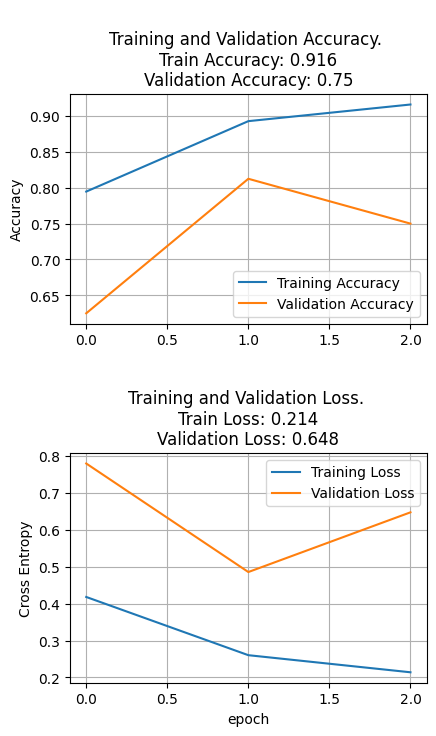

In [ ]:
#Plot the training history with the VGG 16
plot_history(history)

In [ ]:
## Improving the model by unfreezing the base model

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training that was done so far.

nr_base_layers = len(vgg16_base_model.layers)
print("VGG16 base layers = ", nr_base_layers)

history = fit_model(vgg16_model, vgg16_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

VGG16 base layers =  19
Unfreezing number of layers in base model =  4
Epoch 1/5
163/163 [==============================] - 161s 966ms/step - loss: 0.1437 - accuracy: 0.9494 - val_loss: 0.2497 - val_accuracy: 0.8750
Epoch 2/5
163/163 [==============================] - 160s 981ms/step - loss: 0.1038 - accuracy: 0.9615 - val_loss: 0.2576 - val_accuracy: 0.9375
Epoch 3/5
163/163 [==============================] - 160s 980ms/step - loss: 0.0818 - accuracy: 0.9732 - val_loss: 0.0717 - val_accuracy: 1.0000
Epoch 4/5
163/163 [==============================] - 160s 978ms/step - loss: 0.0585 - accuracy: 0.9808 - val_loss: 0.1324 - val_accuracy: 0.9375
Epoch 5/5
163/163 [==============================] - 159s 977ms/step - loss: 0.0628 - accuracy: 0.9795 - val_loss: 0.0582 - val_accuracy: 1.0000


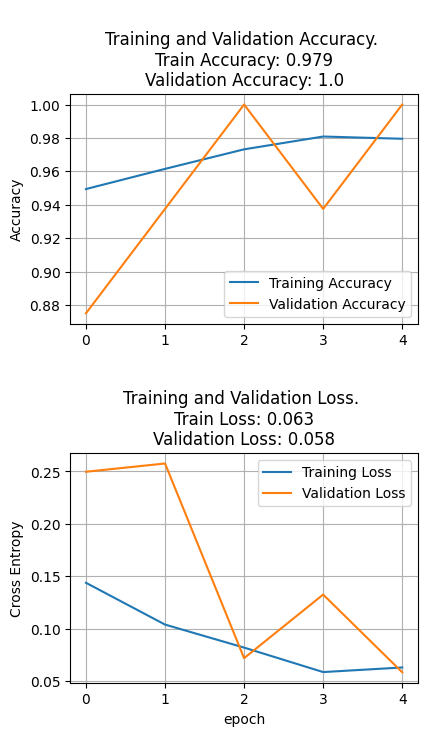

In [ ]:
## Plot the learning history with the improved model
plot_history(history)

In [ ]:
# Accuracy score for the VGG 16 model using the test set (prediction)
accuracy_score = vgg16_model.evaluate(test_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

20/20 [==============================] - 18s 891ms/step - loss: 0.5482 - accuracy: 0.8413
[0.5482422709465027, 0.8413461446762085]
Accuracy: 84.13%
Loss: 0.548


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
test_generator.reset()

vgg16_test_preds = vgg16_model.predict(test_generator)
vgg16_test_pred_classes = np.argmax(vgg16_test_preds, axis=1)

20/20 [==============================] - 19s 909ms/step


In [ ]:
fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(test_generator.classes, vgg16_test_preds[:,1])
auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)
print('Plots the roc curve based of the probabilities, the AUC rate is:', auc_vgg16)

Plots the roc curve based of the probabilities, the AUC rate is: 0.9625575279421433


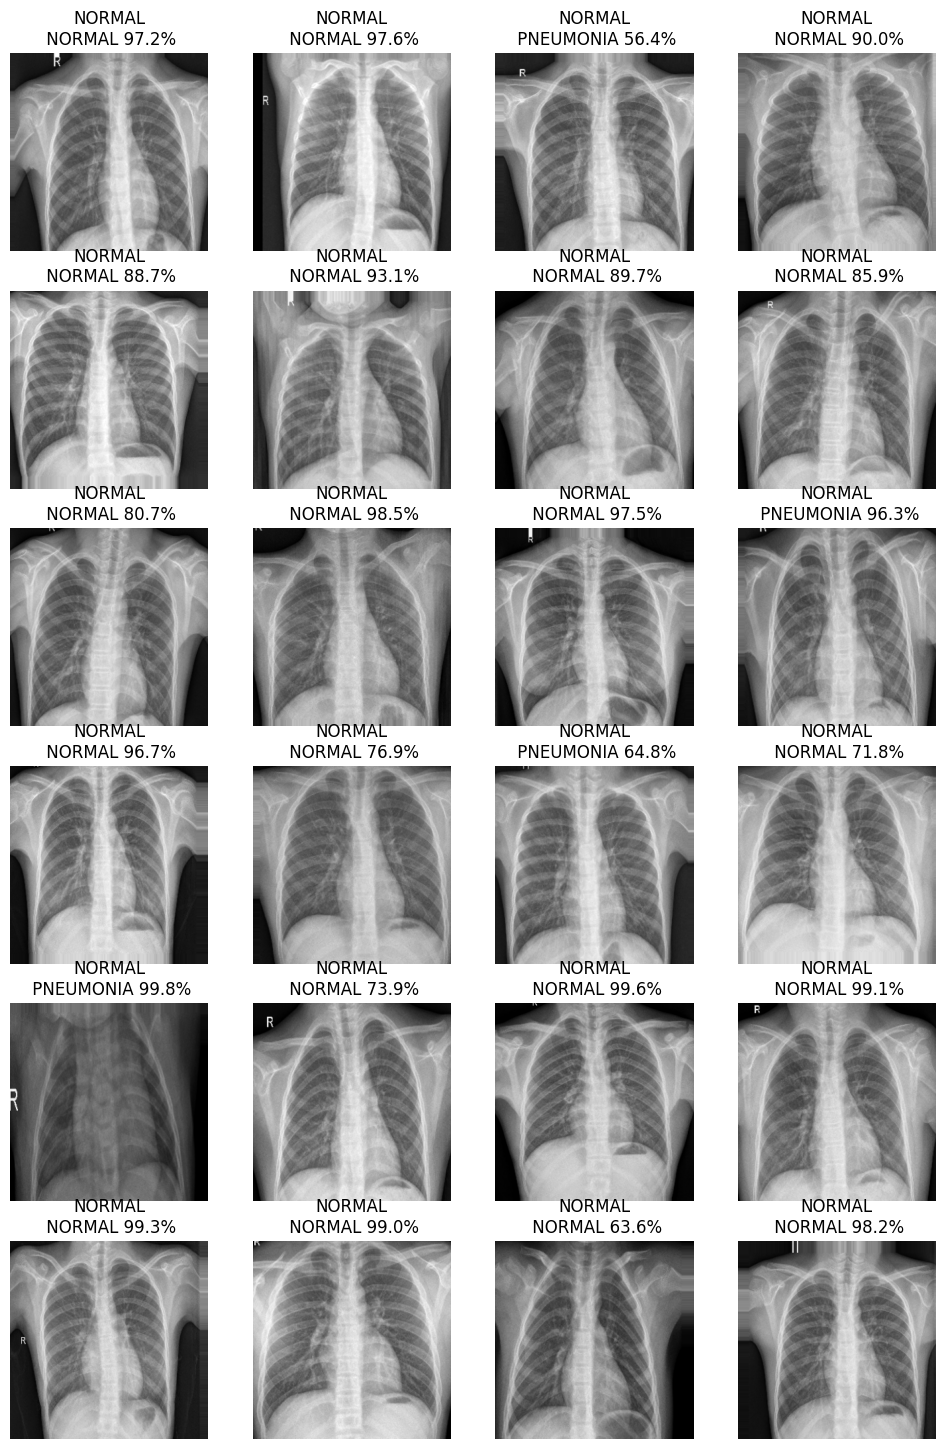

In [ ]:
test_generator.reset()
x,y = next(test_generator)
plot_images(x, y, vgg16_test_preds)

<ipython-input-39-eab6ecafa74f>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


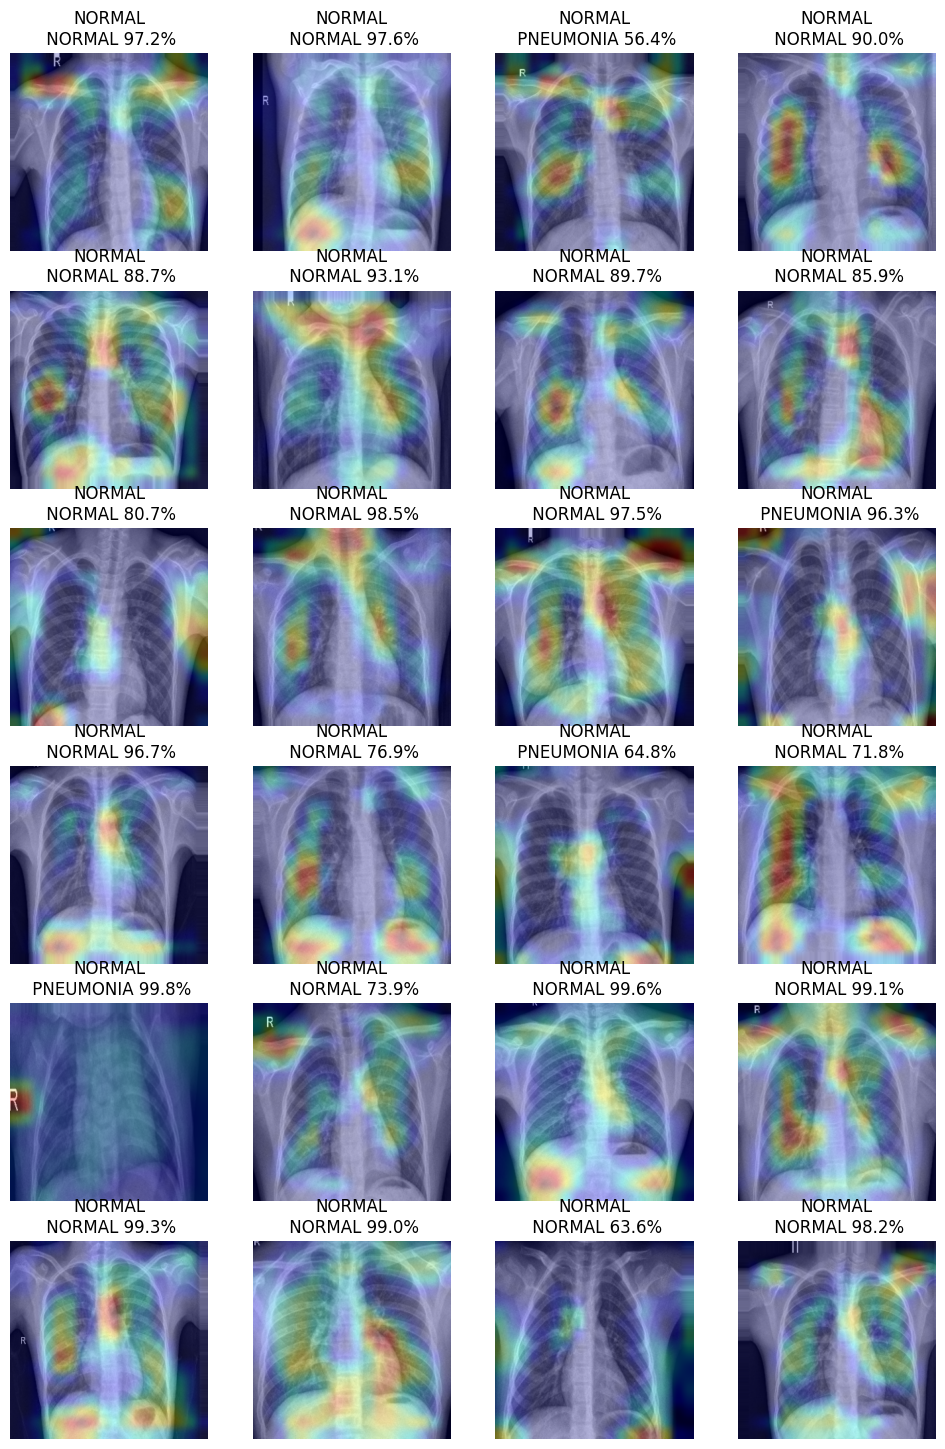

In [ ]:
last_conv_layer_name = "block5_conv3"

heatmaps =[]

for img in x:
    heatmap = make_gradcam_heatmap(img, vgg16_model, last_conv_layer_name)
    heatmaps.append(heatmap)

plot_images(heatmaps, y, vgg16_test_preds)


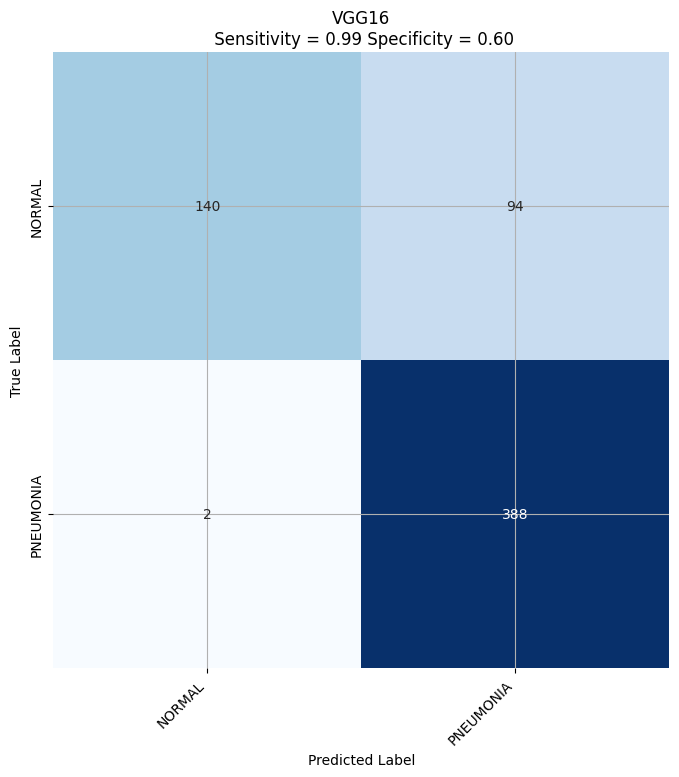

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 8))
true_classes = test_generator.classes
plot_heatmap(true_classes, vgg16_test_pred_classes, class_names, ax1, title = "VGG16")


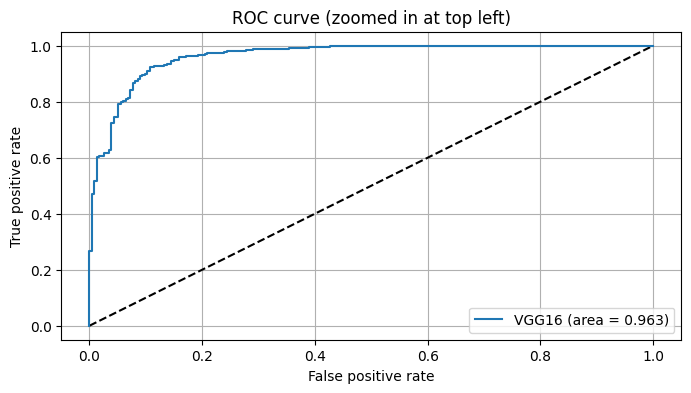

In [ ]:
# Zoom in view of the upper left corner.
#plt.figure(2)
#plt.xlim(0, 0.2)
#plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg16, tpr_vgg16, label='VGG16 (area = {:.3f})'.format(auc_vgg16))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()